In [29]:
def pretty_print_student_info():
    print('************************************')
    print('* Student ID: 99102445              *')
    print('* Name: Ali Nikkhah                 *')
    print('* Course: DeepLearning 1402         *')
    print('************************************')


pretty_print_student_info()

************************************
* Student ID: 99102445              *
* Name: Ali Nikkhah                 *
* Course: DeepLearning 1402         *
************************************


In [18]:
import torch, torchvision
from torch.utils.data import DataLoader,Subset
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import numpy as np
from scipy.signal import convolve2d
from torch import tensor,Tensor
import os


In [19]:

def prepare_mnist_data():
    transform_fn = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ])

    train_dataset = torchvision.datasets.MNIST(root="data/", train=True, transform=transform_fn, download=False)
    n_train_samples = len(train_dataset)
    test_dataset = torchvision.datasets.MNIST(root="data/", train=False, transform=transform_fn, download=False)

    if not os.path.exists("transformed_dataset.pt"):
        random_pairs = np.random.randint(n_train_samples, size=[n_train_samples, 2])
        random_pairs = [(row[0], row[1]) for row in random_pairs]

        transformed_dataset = [
            create_negative_image(train_dataset[pair[0]][0].squeeze(), train_dataset[pair[1]][0].squeeze())
            for pair in tqdm(random_pairs)]

        torch.save(transformed_dataset, 'transformed_dataset.pt')


def create_blurred_mask(shape, iterations: int = 10):
    """
    Create a binary mask with large regions of ones and zeros by applying multiple blurring operations.

    Parameters
    ----------
    shape : tuple
        The shape of the output mask (height, width).
    iterations : int
        The number of times to apply blurring.

    Returns
    -------
    numpy.ndarray
        A binary mask with the specified shape.
    """

    blur_filter_1 = np.array(((0, 0, 0), (0.25, 0.5, 0.25), (0, 0, 0)))
    blur_filter_2 = blur_filter_1.T

    # Create a random binary image
    image = np.random.randint(0, 2, size=shape)

    # Apply blurring operations
    for i in range(iterations):
        image = np.abs(convolve2d(image, blur_filter_1, mode='same') / blur_filter_1.sum())
        image = np.abs(convolve2d(image, blur_filter_2, mode='same') / blur_filter_2.sum())

    mask = np.round(image).astype(np.uint8)

    return torch.tensor(mask)


def create_negative_image(image_1: Tensor, image_2: Tensor):
    assert image_1.shape == image_2.shape, "Incompatible images and mask shapes."

    mask = create_blurred_mask((image_1.shape[0], image_1.shape[1]))

    image_1 = torch.mul(image_1, mask)
    image_2 = torch.mul(image_2, 1 - mask)

    return torch.add(image_1, image_2)


def create_negative_batch(images: Tensor):
    neg_images = []
    batch_size = images.shape[0]
    for _ in range(batch_size):
        idx1, idx2 = np.random.randint(batch_size, size=2)
        neg_images.append(create_negative_image(images[idx1].squeeze(), images[idx2].squeeze()))
    return torch.unsqueeze(torch.stack(neg_images), dim=1)

<Figure size 640x480 with 0 Axes>

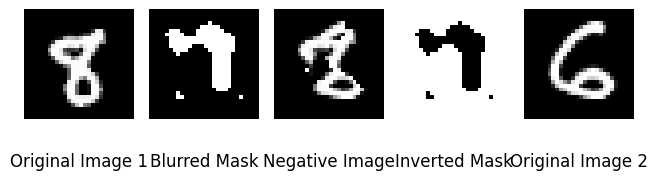

In [34]:
def load_mnist_dataset():
    # Load the MNIST dataset
    mnist_dataset = torchvision.datasets.MNIST(root='data/', download=True)
    return mnist_dataset


def get_random_images_from_mnist(dataset):
    # Get random instances from the MNIST dataset
    image_1, _ = dataset[np.random.randint(len(dataset))]
    image_2, _ = dataset[np.random.randint(len(dataset))]

    image_1 = torch.as_tensor(np.asarray(image_1))
    image_2 = torch.as_tensor(np.asarray(image_2))

    return image_1, image_2


def visualize_images(image_1, image_2):
    mask = create_blurred_mask((28, 28))
    image = create_negative_image(image_1, image_2)

    plt.figure()

    # Create the subplot
    fig, ax = plt.subplots(1, 5)
    images = [image_1, mask, image, 1 - mask, image_2]
    names = ["Original Image 1", "Blurred Mask", "Negative Image", "Inverted Mask", "Original Image 2"]
    # Add the images to the subplot
    for i, img in enumerate(images):
        ax[i].imshow(img, cmap='gray')
        ax[i].axis('off')
        ax[i].set_title(names[i], y=-0.5)

    # Show the subplot
    plt.tight_layout()
    plt.show()


def create_blurred_mask(shape, iterations: int = 10):
    blur_filter_1 = np.array(((0, 0, 0), (0.25, 0.5, 0.25), (0, 0, 0)))
    blur_filter_2 = blur_filter_1.T

    # Create a random binary image
    image = np.random.randint(0, 2, size=shape)

    # Apply blurring operations
    for i in range(iterations):
        image = np.abs(convolve2d(image, blur_filter_1, mode='same') / blur_filter_1.sum())
        image = np.abs(convolve2d(image, blur_filter_2, mode='same') / blur_filter_2.sum())

    mask = np.round(image).astype(np.uint8)

    return torch.tensor(mask)


def create_negative_image(image_1, image_2):
    assert image_1.shape == image_2.shape, "Incompatible images and mask shapes."

    mask = create_blurred_mask((image_1.shape[0], image_1.shape[1]))

    image_1 = torch.mul(image_1, mask)
    image_2 = torch.mul(image_2, 1 - mask)

    return torch.add(image_1, image_2)


# Load the MNIST dataset
mnist_dataset = load_mnist_dataset()

# Get random instances from the MNIST dataset
random_image_1, random_image_2 = get_random_images_from_mnist(mnist_dataset)

# Visualize the images
visualize_images(random_image_1, random_image_2)

In [35]:


def compute_goodness_score(positive_activations, negative_activations, threshold=2):
    positive_goodness = -torch.sum(torch.pow(positive_activations, 2)) + threshold
    negative_goodness = torch.sum(torch.pow(negative_activations, 2)) - threshold
    return torch.add(positive_goodness, negative_goodness)


def calculate_metrics(predictions, labels):
    accuracy = accuracy_score(labels, predictions)
    return dict(accuracy_score=accuracy)


class FeedForwardLayer(nn.Linear):
    def __init__(self, input_features: int, output_features: int, num_epochs: int, bias: bool, device):
        super().__init__(input_features, output_features, bias=bias)
        self.num_epochs = num_epochs
        self.optimizer = torch.optim.Adam(self.parameters())
        self.goodness_score = compute_goodness_score
        self.to(device)
        self.layer_norm = nn.LayerNorm(normalized_shape=[1, output_features]).to(device)

    def train_feed_forward(self, positive_activations, negative_activations):
        self.optimizer.zero_grad()
        goodness = self.goodness_score(positive_activations, negative_activations)
        goodness.backward()
        self.optimizer.step()

    def forward(self, input_data):
        input_data = super().forward(input_data)
        input_data = self.layer_norm(input_data.detach())
        return input_data


class UnsupervisedFeedForward(nn.Module):
    def __init__(self, num_layers: int = 4, num_neurons=2000, input_size: int = 28 * 28, num_epochs: int = 100,
                 bias: bool = True, num_classes: int = 10, hidden_layers_to_log: int = 3,
                 device=torch.device("cuda:0")):
        super().__init__()
        self.hidden_layers_to_log = hidden_layers_to_log
        self.num_epochs = num_epochs
        self.device = device

        feed_forward_layers = [
            FeedForwardLayer(input_features=input_size if idx == 0 else num_neurons,
                             output_features=num_neurons,
                             num_epochs=num_epochs,
                             bias=bias,
                             device=device) for idx in range(num_layers)]

        self.feed_forward_layers = feed_forward_layers
        self.last_layer = nn.Linear(in_features=num_neurons * hidden_layers_to_log,
                                    out_features=num_classes, bias=bias)
        self.to(device)
        self.optimizer = torch.optim.Adam(self.last_layer.parameters())
        self.loss_function = torch.nn.CrossEntropyLoss(reduction="mean")

    def train_feed_forward_layers(self, positive_dataloader, negative_dataloader):
        outer_tqdm = tqdm(range(self.num_epochs), desc="Training Feed Forward Layers", position=0)
        for epoch in outer_tqdm:
            inner_tqdm = tqdm(zip(positive_dataloader, negative_dataloader),
                              desc=f"Training Feed Forward Layers | Epoch {epoch}",
                              leave=False, position=1)
            for pos_data, neg_data in inner_tqdm:
                positive_images, _ = pos_data
                positive_activations = torch.reshape(positive_images, (positive_images.shape[0], 1, -1)).to(self.device)
                negative_activations = torch.reshape(neg_data, (neg_data.shape[0], 1, -1)).to(self.device)

                for idx, layer in enumerate(self.feed_forward_layers):
                    positive_activations = layer(positive_activations)
                    negative_activations = layer(negative_activations)
                    layer.train_feed_forward(positive_activations, negative_activations)

    def train_last_layer(self, dataloader: DataLoader):
        num_examples = len(dataloader)
        outer_tqdm = tqdm(range(self.num_epochs), desc="Training Last Layer", position=0)
        loss_list = []
        for epoch in outer_tqdm:
            epoch_loss = 0
            inner_tqdm = tqdm(dataloader, desc=f"Training Last Layer | Epoch {epoch}", leave=False, position=1)
            for images, labels in inner_tqdm:
                images = images.to(self.device)
                labels = labels.to(self.device)
                self.optimizer.zero_grad()
                predictions = self(images)
                loss = self.loss_function(predictions, labels)
                epoch_loss += loss
                loss.backward()
                self.optimizer.step()
            loss_list.append(epoch_loss / num_examples)
        return [l.detach().cpu().numpy() for l in loss_list]

    def forward(self, image: torch.Tensor):
        image = image.to(self.device)
        image = torch.reshape(image, (image.shape[0], 1, -1))
        concat_output = []
        for idx, layer in enumerate(self.feed_forward_layers):
            image = layer(image)
            if idx > len(self.feed_forward_layers) - self.hidden_layers_to_log - 1:
                concat_output.append(image)
        concat_output = torch.cat(concat_output, 2)
        logits = self.last_layer(concat_output)
        return logits.squeeze()

    def evaluate(self, dataloader: DataLoader, dataset_type: str = "train"):
        self.eval()
        inner_tqdm = tqdm(dataloader, desc=f"Evaluating model", leave=False, position=1)
        all_labels = []
        all_predictions = []
        for images, labels in inner_tqdm:
            images = images.to(self.device)
            labels = labels.to(self.device)
            predictions = self(images)
            predictions = torch.argmax(predictions, 1)
            all_labels.append(labels.detach().cpu())
            all_predictions.append(predictions.detach().cpu())
        all_labels = torch.cat(all_labels, 0).numpy()
        all_predictions = torch.cat(all_predictions, 0).numpy()
        metrics_dict = calculate_metrics(all_predictions, all_labels)
        print('************************************')
        print('* Final Results on Accuracy          *')
        print(f"{dataset_type} dataset scores: ", "\n \n \n ".join([f"{key}: {100*value}" for key, value in metrics_dict.items()]))
        print('*                                  *')
        print('************************************')



def train_model(model: UnsupervisedFeedForward, positive_dataloader: DataLoader, negative_dataloader: DataLoader):
    model.train()
    model.train_feed_forward_layers(positive_dataloader, negative_dataloader)
    return model.train_last_layer(positive_dataloader)


def plot_training_loss(loss_values):
    # plot the loss over epochs
    fig = plt.figure()
    plt.plot(list(range(len(loss_values))), loss_values)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Plot")
    plt.savefig("Loss_Plot.png")
    plt.show()






In [36]:
# Load the MNIST dataset
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
pos_dataset = torchvision.datasets.MNIST(root='data/', download=False, transform=transform, train=True)
# pos_dataset = Subset(pos_dataset, list(range(1000)))
# Create the data loader
pos_dataloader = DataLoader(pos_dataset, batch_size=64, shuffle=True, num_workers=4)
prepare_mnist_data()
# Load the transformed images
neg_dataset = torch.stack(torch.load('transformed_dataset.pt'))
# Create the data loader
neg_dataloader = DataLoader(neg_dataset, batch_size=64, shuffle=True, num_workers=4)

# Load the test images
test_dataset = torchvision.datasets.MNIST(root='data/', train=False, download=False, transform=transform)
# Create the data loader
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [38]:
device = torch.device("cuda:0")
unsupervised_ff = UnsupervisedFeedForward(device=device, num_epochs=12)

loss = train_model(unsupervised_ff, pos_dataloader, neg_dataloader)

Training Feed Forward Layers:   0%|          | 0/12 [00:00<?, ?it/s]
Training Feed Forward Layers | Epoch 0: 0it [00:00, ?it/s]
Training Feed Forward Layers | Epoch 0: 9it [00:00, 77.08it/s]
Training Feed Forward Layers | Epoch 0: 17it [00:00, 72.21it/s]
Training Feed Forward Layers | Epoch 0: 25it [00:00, 72.28it/s]
Training Feed Forward Layers | Epoch 0: 33it [00:00, 73.57it/s]
Training Feed Forward Layers | Epoch 0: 41it [00:00, 71.94it/s]
Training Feed Forward Layers | Epoch 0: 49it [00:00, 72.65it/s]
Training Feed Forward Layers | Epoch 0: 57it [00:00, 71.76it/s]
Training Feed Forward Layers | Epoch 0: 65it [00:00, 74.18it/s]
Training Feed Forward Layers | Epoch 0: 73it [00:01, 72.77it/s]
Training Feed Forward Layers | Epoch 0: 81it [00:01, 73.04it/s]
Training Feed Forward Layers | Epoch 0: 89it [00:01, 74.21it/s]
Training Feed Forward Layers | Epoch 0: 97it [00:01, 70.93it/s]
Training Feed Forward Layers | Epoch 0: 105it [00:01, 72.29it/s]
Training Feed Forward Layers | Epoch 0: 

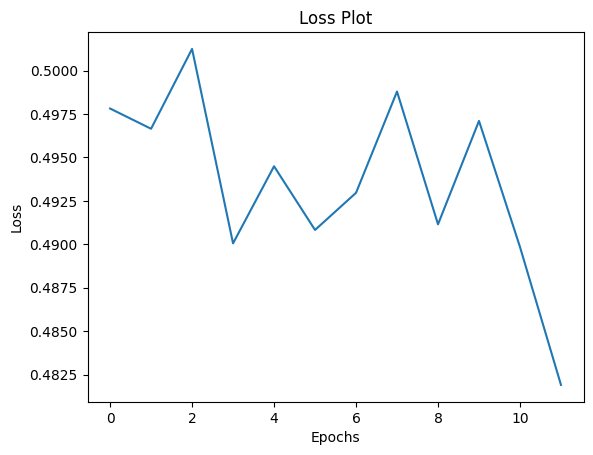

In [27]:
plot_training_loss(loss)

In [33]:
unsupervised_ff.evaluate(pos_dataloader, dataset_type="Train")
unsupervised_ff.evaluate(test_dataloader, dataset_type="Test")


Evaluating model:   0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(

Evaluating model:  99%|█████████▉| 932/938 [00:10<00:00, 75.18it/s]
                                                                   

Train dataset scores:  accuracy_score: 0.9128333333333334



Evaluating model:   0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(

Evaluating model:  92%|█████████▏| 145/157 [00:02<00:00, 73.38it/s]
                                                                   

Test dataset scores:  accuracy_score: 0.9054
